In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.signal import find_peaks, peak_prominences
import bottleneck as bn

In [2]:
d4 = pd.read_csv('data/battery_data/2020-4.csv', index_col='timestamp')
d5 = pd.read_csv('data/battery_data/2020-5.csv', index_col='timestamp')
d6 = pd.read_csv('data/battery_data/2020-6.csv', index_col='timestamp')
d7 = pd.read_csv('data/battery_data/2020-7.csv', index_col='timestamp')
d8 = pd.read_csv('data/battery_data/2020-8.csv', index_col='timestamp')
d9 = pd.read_csv('data/battery_data/2020-9.csv', index_col='timestamp')

/home/iross/.conda/envs/challenge-1/lib/python3.9/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
d4.index = pd.to_datetime(d4.index, unit='s')
d5.index = pd.to_datetime(d5.index, unit='s')
d6.index = pd.to_datetime(d6.index, unit='s')
d7.index = pd.to_datetime(d7.index, unit='s')
d8.index = pd.to_datetime(d8.index, unit='s')
d9.index = pd.to_datetime(d9.index, unit='s')

In [4]:
d = d4
d = d.append(d5)
d = d.append(d6)
d = d.append(d7)
d = d.append(d8)
d = d.append(d9)

In [ ]:
d[['current','voltage']].plot(subplots=True, figsize=(9,6))

In [5]:
peaks, _ = find_peaks(d.voltage, height=4.12, width=30, prominence=0.05, distance=150)
plateaus = np.zeros_like(peaks)
starts = np.zeros_like(peaks)

search_window = 3 * 3600 # 3 hours
min_plateau = 10 * 60 # 10 minutes

for i in range(peaks.size):
    p = peaks[i]
    print(d.index[p], d.voltage[p])
    
    search = p
    while search < p + search_window and d.voltage[search] > 4.0:
        search += 1
    
    if d.voltage[search] > 4.0:
        continue
            
    plat = search
    v_plat = d.voltage[plat]
    
    flat = False
    while not flat:
        if d.voltage[plat] < 3.8 or d.voltage[plat] > v_plat + 0.01:
            break
            
        if d.voltage[plat + 1] < v_plat or d.voltage[plat + 20] < v_plat:
            plat += 1
            v_plat = d.voltage[plat]
        else:
            flat = True
            
    if not flat:
        continue
            
    ok = True
    for check in range(min_plateau):
        if abs(d.voltage[plat + check] - v_plat) > 0.01:
            ok = False
            break
        
    if ok:
        print("  OK")
        plateaus[i] = plat
        s = plat
        while s > p and d.current[s] != 0:
            s -= 1
        starts[i] = s


2020-04-01 04:05:50 4.129
2020-04-01 08:59:34 4.15
2020-04-01 17:38:45 4.148
2020-04-02 02:19:43 4.148
2020-04-03 02:31:08 4.123
  OK
2020-04-03 19:58:07 4.126
  OK
2020-04-04 13:25:37 4.127
  OK
2020-04-05 06:53:21 4.126
  OK
2020-04-06 00:20:17 4.125
  OK
2020-04-06 17:47:49 4.125
  OK
2020-04-07 11:15:15 4.125
  OK
2020-04-08 04:42:43 4.125
  OK
2020-04-08 22:10:08 4.125
  OK
2020-04-09 15:37:20 4.125
  OK
2020-04-10 09:04:39 4.125
  OK
2020-04-11 02:32:13 4.125
  OK
2020-04-11 19:59:31 4.125
  OK
2020-04-12 13:26:59 4.126
  OK
2020-04-13 06:54:06 4.125
  OK
2020-04-14 00:21:40 4.126
  OK
2020-04-14 17:49:02 4.125
  OK
2020-04-15 11:16:27 4.126
  OK
2020-04-16 04:43:58 4.126
  OK
2020-04-16 22:11:13 4.125
  OK
2020-04-17 15:38:31 4.126
  OK
2020-04-18 09:06:01 4.127
  OK
2020-04-19 02:33:24 4.126
  OK
2020-04-19 20:00:52 4.126
  OK
2020-04-20 13:28:18 4.125
  OK
2020-04-21 06:55:20 4.126
  OK
2020-04-22 00:22:35 4.126
  OK
2020-04-22 17:49:59 4.126
  OK
2020-04-23 11:17:11 4.126
  O

In [6]:
peaks = peaks[plateaus != 0]
starts = starts[plateaus != 0]
plateaus = plateaus[plateaus != 0]

In [ ]:
plt.scatter(d.index[peaks], d.voltage[peaks], color='red')
plt.scatter(d.index[plateaus], d.voltage[plateaus], color='green')
plt.scatter(d.index[starts], d.voltage[starts], color='orange')
d.voltage.plot(figsize=(9,5))

In [7]:
refc = pd.read_csv('data/testbench_results/testbench_results_first3months.csv')
refc.index = pd.to_datetime(refc.timestamp, unit='s')
refc.Q_discharge = -refc.Q_discharge

In [8]:
refc

,timestamp,Q_discharge
timestamp,,
2020-04-01 08:49:50,1.585731e+09,11.403694
2020-04-24 07:14:18,1.587712e+09,11.341753
2020-05-22 05:56:22,1.590127e+09,11.307378
2020-06-17 10:59:20,1.592392e+09,11.277411


In [30]:
vars = pd.DataFrame({'timestamp': d.index[peaks],
                     'dt': plateaus - starts,
                     'dv': d.voltage[starts].values - d.voltage[plateaus].values,
                     'dvdt': (d.voltage[starts].values - d.voltage[plateaus].values) / (plateaus - starts) })
vars['smoothed'] = savgol_filter(vars.dvdt, 51, 1)
vars['dsmoothed'] = np.abs(vars.smoothed.diff())
vars.dsmoothed = vars.dsmoothed / np.max(vars.dsmoothed)
vars['predict'] = ''
vars.dropna(inplace=True)
vars.reset_index(inplace=True)
vars['predict'][0] = refc.Q_discharge[0]
for i in vars.index[1:]:
    damage = 0.00075 * vars.dsmoothed[i]
    vars.predict[i] = vars.predict[i-1] * (1 - damage)
vars.index = pd.to_datetime(vars.timestamp, unit='s')


<ipython-input-30-fc2211467a1a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vars['predict'][0] = refc.Q_discharge[0]
<ipython-input-30-fc2211467a1a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vars.predict[i] = vars.predict[i-1] * (1 - damage)


In [10]:
vars.head()

,index,timestamp,dt,dv,dvdt,smoothed,dsmoothed,predict
timestamp,,,,,,,,
2020-04-22 00:22:35,26,2020-04-22 00:22:35,585,0.128,0.000219,0.000217,0.487092,11.403694
2020-04-22 17:49:59,27,2020-04-22 17:49:59,583,0.127,0.000218,0.000217,0.505076,11.374895
2020-04-23 11:17:11,28,2020-04-23 11:17:11,584,0.127,0.000217,0.000217,0.513285,11.345702
2020-04-24 04:44:43,29,2020-04-24 04:44:43,583,0.127,0.000218,0.000217,0.513995,11.316544
2020-04-29 02:33:14,30,2020-04-29 02:33:14,602,0.128,0.000213,0.000217,0.515462,11.287378


<IPython.core.display.Javascript object>


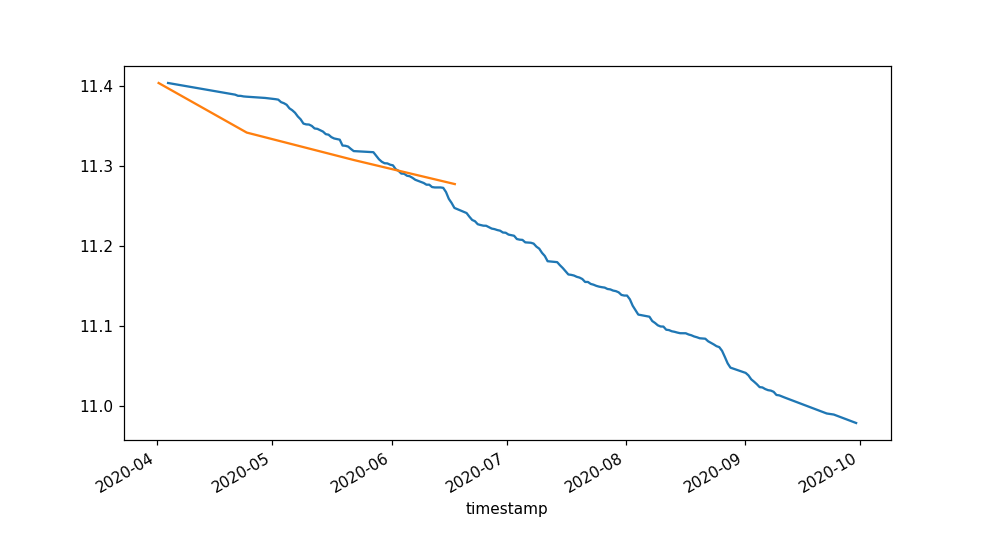

<AxesSubplot:xlabel='timestamp'>

In [31]:
vars.predict.plot(figsize=(9,5))
refc.Q_discharge.plot()

In [34]:
predict_dates = pd.Series(['2020-07-11', '2020-08-04', '2020-08-28', '2020-09-22', '2020-10-01'])
predict = pd.DataFrame(index=predict_dates, columns=['capacity'])
for pred in predict.index:
    icyc = vars.index.get_loc(pred, method='nearest')
    predict['capacity'][pred] = np.mean(vars.predict[icyc])

In [35]:
predict

,capacity
2020-07-11,11.181035
2020-08-04,11.114373
2020-08-28,11.048079
2020-09-22,10.990796
2020-10-01,10.97891
